In [21]:
import numpy as np
import torch
from problems.toy_biobjective import circle_points, create_pf
from problems.convex_biobjective import create_pf1
from solvers import PNG_solver
import matplotlib.pyplot as plt
from latex_utils import latexify
import matplotlib as mpl
import time

# Params for PLT

In [22]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

# Setup params

In [51]:

# adjust criterion F
#criterion = 'template'
#criterion = 'complex cos'
criterion = 'utility'
method = 'PNGD NORMAL'
#method = 'PNGD COSINE'
K = 4       # Number of trajectories
n = 2      # dim of solution space
m = 2       # dim of objective space
rs = circle_points(K)  # preference
pmtl_K = 5
pmtl_refs = circle_points(pmtl_K, 0, np.pi / 2)

color_list = ['#28B463', '#326CAE', '#FFC300', '#FF5733']
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 18,
         }
font_legend = {'family': 'Times New Roman',
               'weight': 'normal',
                'size': 18,
               }

max_iters = 75 # iteration for  PNGD normal
max_iters1 = 75 # iteration for PNGD COSINE
contexts = [[0.2, 0.8], [0.4, 0.6],[0.8,0.2],[0.6,0.4]] 
C = 1e-5 # penalty
alpha = 0.5
threshold = 0.1
start = -1
step_size = 0.05
step_size1 = 0.05
count =0

# Run model

In [52]:
result_all = []
result_all1 = []
for id, context in enumerate(contexts):
    count+=1
    last_ls = []
    x0 = np.zeros(n)
    x0[range(0, n, 2)] = 0.6
    x0[range(1, n, 2)] = -.3
    x1 = np.zeros(n)
    x1[range(0, n, 2)] = 0.6
    x1[range(1, n, 2)] = -.3
    e_solver = PNG_solver(max_iters=max_iters, n_dim=n, step_size=step_size)
    e_solver1 = PNG_solver(max_iters=max_iters1, n_dim=n, step_size=step_size1)
    x0 = torch.tensor(list(x0)).float().unsqueeze(0)
    #x1 = torch.tensor(list(x1)).float().unsqueeze(0)
    x0.requires_grad = True
    #x1.requires_grad = True
    start1 = time.time()
    if method == "PNGD NORMAL":
        _, res = e_solver.optimize(x0, criterion=criterion, context=context, alpha=alpha, threshold=threshold, start=start) # PNGD normal
    elif method == "PNGD COSINE":
        _, res = e_solver1.optimize1(x0, criterion=criterion, context=context, alpha=alpha, threshold=threshold, start=start,C=C) # PNGD COSINE
    end1 = time.time()
    
    # start2 = time.time()
    # _, res1 = e_solver1.optimize1(x1, criterion=criterion, context=context, alpha=alpha, threshold=threshold, start=start,C=C)
    # #print(res1.shape)
    # end2 = time.time()
    if count==1:
        print("Time1: ",end1-start1)
        #print("Time2: ",end2-start2)
    result_all.append(res)
    #result_all1.append(res1)


latexify(fig_width=5., fig_height=5.)
ss, mi = 0.1, 100
pf = create_pf1()
# pf = create_pf1()
fig, ax = plt.subplots()

shape = ','
shape1 = '+'
size = 50
target_size = 500

def find_target(pf, criterion='template', context=None):
    if criterion == 'template':
        F = context[1] * (pf[:, 0] - context[0]) ** 2 + context[0] * (pf[:, 1] - context[1]) ** 2
        # F = context[0] * (pf[:, 0] - context[0]) ** 2 + context[1] * (pf[:, 1] - context[1]) ** 2
        return pf[F.argmin(), :]
    if criterion == 'complex cos':
        def sigmoid(x):
            return 1/(1 + np.exp(-x))
        F = -np.cos(0.5 * 3.14159 * (pf[:, 0] - context[0])) * ((np.cos(3.14159 * (pf[:, 1] - context[1]))) ** 2)
        return pf[F.argmin(), :]
    if criterion == 'utility':
        #F = context[0]*np.log(pf[:, 0]) + context[1]*np.log(pf[:, 1])
        F = pf[:, 0]*context[0] + pf[:, 1]*context[1]
        #F = ((pf[:, 0]+1)**context[0])*((pf[:, 1]+2)**context[1])
        return pf[F.argmin(), :]



Time1:  4.49586296081543


e:\Python3.7\lib\_collections_abc.py:841: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


# Plot trajectory

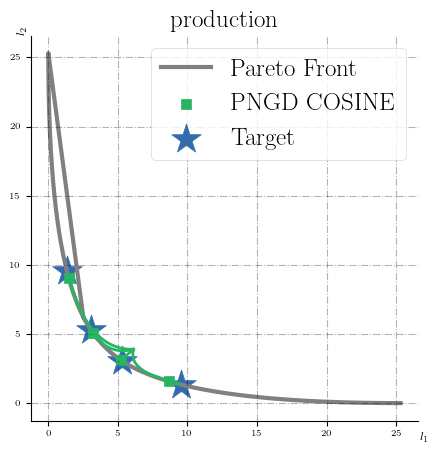

In [47]:
for id, context in enumerate(contexts):
    last_ls = []
    res = result_all[id]['ls']
    #res1 = result_all1[id]['ls']
    # plot the trajectory
    if id == 0:
        ax.scatter(res[-1, 0], res[-1, 1], s=size, c=color_list[0], marker=shape, alpha=1, label= method)
        #ax.scatter(res1[-1, 0], res1[-1, 1], s=size, c=color_list[2], marker=shape, alpha=1, label='PNG cosin (penalty)')
    else:
        ax.scatter(res[-1, 0], res[-1, 1], s=size, c=color_list[0], marker=shape, alpha=1)
        #ax.scatter(res1[-1, 0], res1[-1, 1], s=size, c=color_list[2], marker=shape, alpha=1)
    ax.plot(res[:, 0], res[:, 1], c=color_list[0], alpha=1, lw=2)
    #ax.plot(res1[:, 0], res1[:, 1], c=color_list[2], alpha=1, lw=2)
    if criterion == 'template' or criterion == 'complex cos' or criterion == 'utility':
        target = find_target(pf, criterion=criterion, context=context)
        if id == 0:
            # ax.scatter(ref_vec[0], ref_vec[1], s=size, c=color_list[1], marker=shape, alpha=1, label='Ref Vector')
            ax.scatter(target[0], target[1], s=target_size, c=color_list[1], marker='*', alpha=1, label='Target', zorder=0)
        else:
            ax.scatter(target[0], target[1], s=target_size, c=color_list[1], marker='*', alpha=1, zorder=0)

ax.set_xlabel(r'$l_1$')
ax.set_ylabel(r'$l_2$')
ax.xaxis.set_label_coords(1.015, -0.03)
ax.yaxis.set_label_coords(-0.01, 1.01)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(pf[:, 0], pf[:, 1], lw=3, c='grey', label='Pareto Front',zorder=0)
ax.grid(color="k", linestyle="-.", alpha=0.3, zorder=0)
# plt.legend(prop=font_legend, loc='upper right')
plt.legend(prop=font_legend)
if criterion == 'complex cos':
    plt.title('complex cosine', **font1)
if criterion == 'template':
    plt.title('weighted distance', **font1)
if criterion == 'utility':
    plt.title('production', **font1)
plt.show()


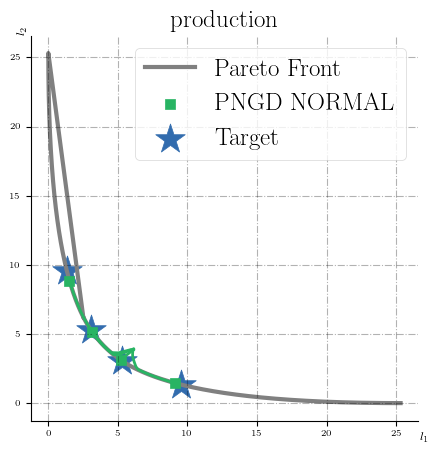

In [53]:
for id, context in enumerate(contexts):
    last_ls = []
    res = result_all[id]['ls']
    #res1 = result_all1[id]['ls']
    # plot the trajectory
    if id == 0:
        ax.scatter(res[-1, 0], res[-1, 1], s=size, c=color_list[0], marker=shape, alpha=1, label= method)
        #ax.scatter(res1[-1, 0], res1[-1, 1], s=size, c=color_list[2], marker=shape, alpha=1, label='PNG cosin (penalty)')
    else:
        ax.scatter(res[-1, 0], res[-1, 1], s=size, c=color_list[0], marker=shape, alpha=1)
        #ax.scatter(res1[-1, 0], res1[-1, 1], s=size, c=color_list[2], marker=shape, alpha=1)
    ax.plot(res[:, 0], res[:, 1], c=color_list[0], alpha=1, lw=2)
    #ax.plot(res1[:, 0], res1[:, 1], c=color_list[2], alpha=1, lw=2)
    if criterion == 'template' or criterion == 'complex cos' or criterion == 'utility':
        target = find_target(pf, criterion=criterion, context=context)
        if id == 0:
            # ax.scatter(ref_vec[0], ref_vec[1], s=size, c=color_list[1], marker=shape, alpha=1, label='Ref Vector')
            ax.scatter(target[0], target[1], s=target_size, c=color_list[1], marker='*', alpha=1, label='Target', zorder=0)
        else:
            ax.scatter(target[0], target[1], s=target_size, c=color_list[1], marker='*', alpha=1, zorder=0)

ax.set_xlabel(r'$l_1$')
ax.set_ylabel(r'$l_2$')
ax.xaxis.set_label_coords(1.015, -0.03)
ax.yaxis.set_label_coords(-0.01, 1.01)
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.plot(pf[:, 0], pf[:, 1], lw=3, c='grey', label='Pareto Front',zorder=0)
ax.grid(color="k", linestyle="-.", alpha=0.3, zorder=0)
# plt.legend(prop=font_legend, loc='upper right')
plt.legend(prop=font_legend)
if criterion == 'complex cos':
    plt.title('complex cosine', **font1)
if criterion == 'template':
    plt.title('weighted distance', **font1)
if criterion == 'utility':
    plt.title('production', **font1)
plt.show()
